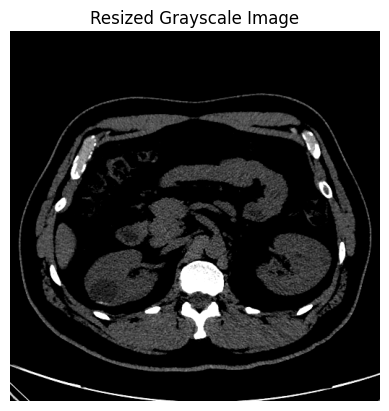

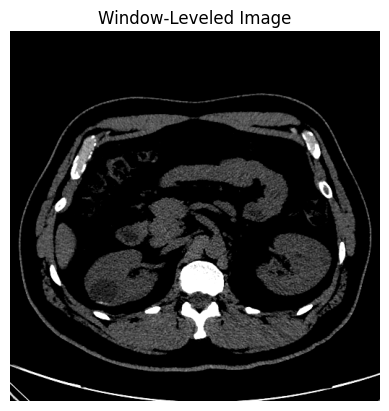

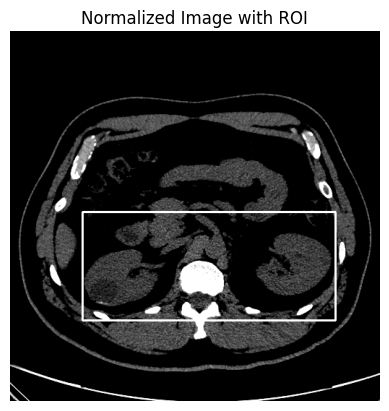

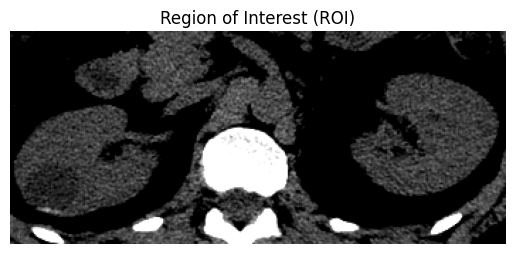

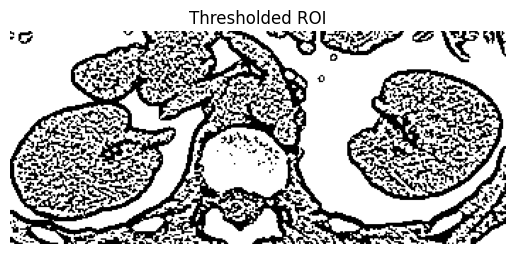

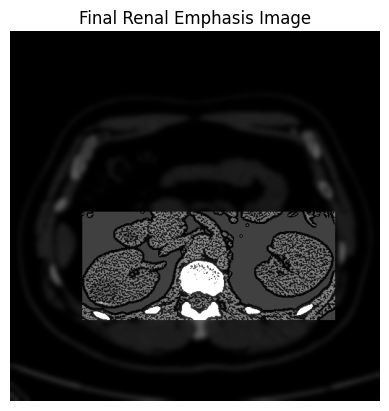

False

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to display the image with a rectangle overlay for the ROI
def display_image_with_roi(image, roi_coords, title="Image with ROI"):
    image_with_roi = image.copy()
    x, y, w, h = roi_coords
    cv2.rectangle(image_with_roi, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Blue rectangle for ROI
    plt.imshow(image_with_roi, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Load the image
image_path = 'Cyst- (19).jpg'
image = cv2.imread(image_path)

# Convert RGB to Grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Resize the Image to a standard size (e.g., 512x512)
standard_size = (512, 512)
resized_image = cv2.resize(gray_image, standard_size)

# Display the grayscale image
plt.imshow(resized_image, cmap='gray')
plt.title("Resized Grayscale Image")
plt.axis('off')
plt.show()

# Apply CT Window Leveling
def window_level(image, level, width):
    min_intensity = level - (width / 2)
    max_intensity = level + (width / 2)
    windowed_image = np.clip(image, min_intensity, max_intensity)
    windowed_image = ((windowed_image - min_intensity) / (max_intensity - min_intensity)) * 255
    return windowed_image.astype(np.uint8)

# Example window level values for renal imaging
window_level_value = 40
window_width_value = 400
normalized_image = window_level(resized_image, window_level_value, window_width_value)

# Display the window-leveled image
plt.imshow(normalized_image, cmap='gray')
plt.title("Window-Leveled Image")
plt.axis('off')
plt.show()

# Define the region of interest (ROI) for the renal area
# Coordinates are in the format: (x, y, width, height)
roi_coords = (100, 250, 350, 150)  # Example coordinates, adjust as needed

# Display the image with the ROI rectangle
display_image_with_roi(normalized_image, roi_coords, title="Normalized Image with ROI")

# Extract the ROI from the normalized image
x, y, w, h = roi_coords
roi = normalized_image[y:y+h, x:x+w]

# Display the ROI
plt.imshow(roi, cmap='gray')
plt.title("Region of Interest (ROI)")
plt.axis('off')
plt.show()

# Use adaptive thresholding to emphasize the renal area within the ROI
roi_thresholded = cv2.adaptiveThreshold(roi, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

# Display the thresholded ROI
plt.imshow(roi_thresholded, cmap='gray')
plt.title("Thresholded ROI")
plt.axis('off')
plt.show()

# Create a mask for the renal area and place it back on the original image size
renal_mask = np.zeros_like(normalized_image)
renal_mask[y:y+h, x:x+w] = roi_thresholded

# Apply the mask to the normalized image
renal_emphasis = cv2.bitwise_and(normalized_image, renal_mask)

# Optionally, blend the renal area with a blurred background
blurred_background = cv2.GaussianBlur(normalized_image, (21, 21), 0)
renal_area_only = cv2.bitwise_and(renal_emphasis, renal_mask)
suppressed_background = cv2.bitwise_and(blurred_background, cv2.bitwise_not(renal_mask))
final_image = cv2.addWeighted(renal_area_only, 1, suppressed_background, 0.5, 0)

# Display the final image
plt.imshow(final_image, cmap='gray')
plt.title("Final Renal Emphasis Image")
plt.axis('off')
plt.show()

# Save the output
output_path = '/mnt/data/processed_ct_image_renal_emphasis.png'
cv2.imwrite(output_path, final_image)


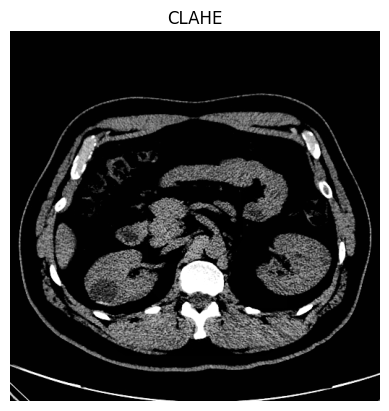

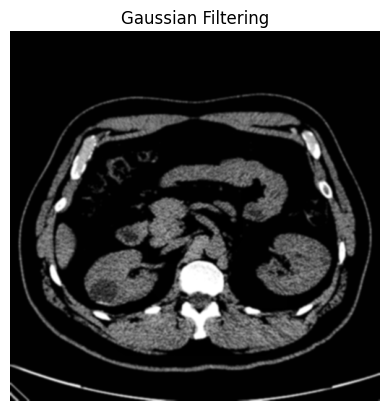

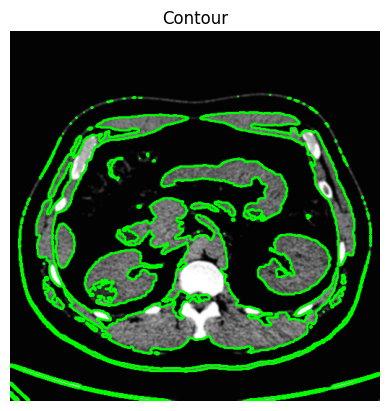

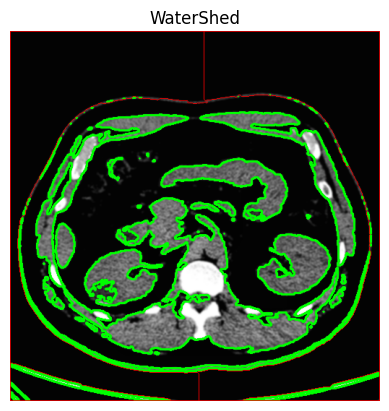

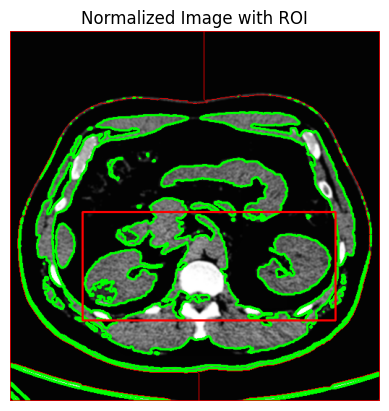

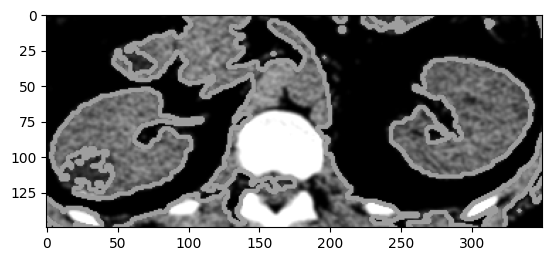

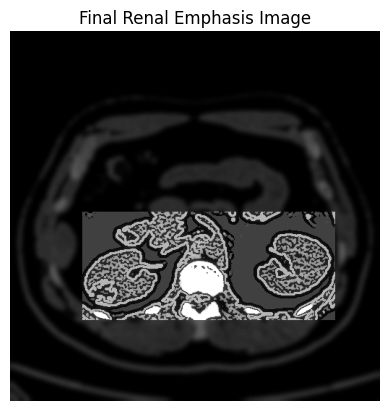

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def clahe(image_path):
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clahe_image = clahe.apply(gray_image)
    plt.imshow(clahe_image, cmap='gray')
    plt.title("CLAHE")
    plt.axis('off')
    plt.show()
    return clahe_image

def gaussian_blur(image):
    kernel_size = (5, 5)
    sigma = 0
    filtered_image = cv2.GaussianBlur(image, kernel_size, sigma)
    plt.imshow(filtered_image, cmap='gray')
    plt.title("Gaussian Filtering")
    plt.axis('off')
    plt.show()
    return filtered_image

def find_contour(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    _, binary_image = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_image = cv2.drawContours(cv2.cvtColor(image, cv2.COLOR_GRAY2BGR), contours, -1, (0, 255, 0), 2)
    plt.imshow(contour_image, cmap='gray')
    plt.title("Contour")
    plt.axis('off')
    plt.show()
    return contour_image

def watershed_segmentation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    markers = cv2.watershed(image, markers)
    image[markers == -1] = [255, 0, 0]
    plt.imshow(image, cmap='gray')
    plt.title("WaterShed")
    plt.axis('off')
    plt.show()
    return image

def display_image_with_roi(image, roi_coords, title="Image with ROI"):
    image_with_roi = image.copy()
    x, y, w, h = roi_coords
    cv2.rectangle(image_with_roi, (x, y), (x + w, y + h), (255, 0, 0), 2)
    plt.imshow(image_with_roi, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def window_level(image, level, width):
    min_intensity = level - (width / 2)
    max_intensity = level + (width / 2)
    windowed_image = np.clip(image, min_intensity, max_intensity)
    windowed_image = ((windowed_image - min_intensity) / (max_intensity - min_intensity)) * 255
    return windowed_image.astype(np.uint8)

def roi(image):
    roi_image = image
    gray_image = cv2.cvtColor(roi_image, cv2.COLOR_BGR2GRAY)
    standard_size = (512, 512)
    resized_image = cv2.resize(gray_image, standard_size)
    window_level_value = 40
    window_width_value = 400
    normalized_image = window_level(resized_image, window_level_value, window_width_value)
    roi_coords = (100, 250, 350, 150) 
    display_image_with_roi(roi_image, roi_coords, title="Normalized Image with ROI")
   
    x, y, w, h = roi_coords
    roi = normalized_image[y:y+h, x:x+w]
    plt.imshow(roi, cmap='gray')
    plt.show()
    roi_thresholded = cv2.adaptiveThreshold(roi, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    renal_mask = np.zeros_like(normalized_image)
    renal_mask[y:y+h, x:x+w] = roi_thresholded
    renal_emphasis = cv2.bitwise_and(normalized_image, renal_mask)
    blurred_background = cv2.GaussianBlur(normalized_image, (21, 21), 0)
    renal_area_only = cv2.bitwise_and(renal_emphasis, renal_mask)
    suppressed_background = cv2.bitwise_and(blurred_background, cv2.bitwise_not(renal_mask))
    final_image = cv2.addWeighted(renal_area_only, 1, suppressed_background, 0.5, 0)
    plt.imshow(final_image, cmap='gray')
    plt.title("Final Renal Emphasis Image")
    plt.axis('off')
    plt.show()

# Load the image and apply the processing steps sequentially
image_path = 'Cyst- (19).jpg'
preprocessed_image = clahe(image_path)
preprocessed_image = gaussian_blur(preprocessed_image)
preprocessed_image = find_contour(preprocessed_image)
preprocessed_image = watershed_segmentation(preprocessed_image)
roi(preprocessed_image)


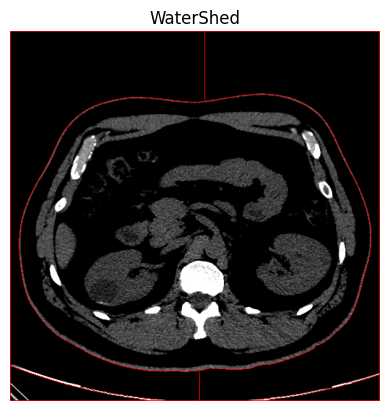

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def clahe(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Read image as grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    markers = cv2.watershed(image, markers)
    image[markers == -1] = [255, 0, 0]
    plt.imshow(image, cmap='gray')
    plt.title("WaterShed")
    plt.axis('off')
    plt.show()
    return image

image_path = 'Cyst- (19).jpg'
preprocessed_image = clahe(image_path)


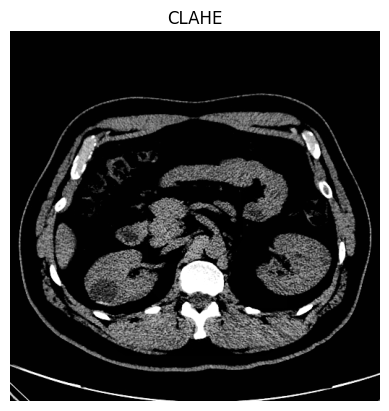

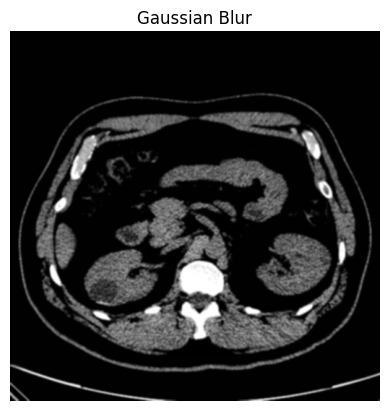

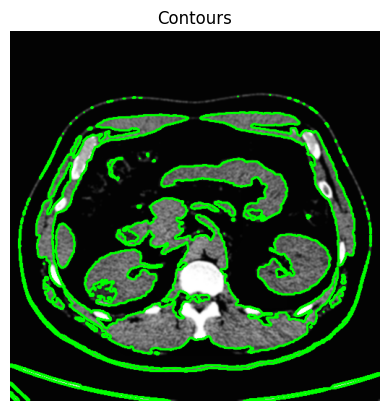

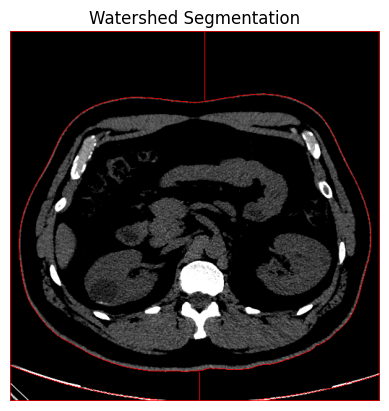

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\thresh.cpp:1674: error: (-215:Assertion failed) src.type() == CV_8UC1 in function 'cv::adaptiveThreshold'


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_image(image_path):
    """ Load an image from disk. """
    return cv2.imread(image_path)

def clahe(image):
    """ Apply Contrast Limited Adaptive Histogram Equalization (CLAHE). """
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(gray_image)

def gaussian_blur(image):
    """ Apply Gaussian Blur to the image. """
    return cv2.GaussianBlur(image, (5, 5), 0)

def find_contours(image):
    """ Find contours in the image and draw them. """
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    _, binary_image = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_image = cv2.drawContours(cv2.cvtColor(image, cv2.COLOR_GRAY2BGR), contours, -1, (0, 255, 0), 2)
    return contour_image

def watershed_segmentation(image):
    """ Apply Watershed Segmentation to the image. """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    markers = cv2.watershed(image, markers)
    image[markers == -1] = [255, 0, 0]
    return image

def display_image(image, title="Image", cmap='gray'):
    """ Display an image using matplotlib. """
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

def window_level(image, level, width):
    """ Apply window level adjustment to the image. """
    min_intensity = level - (width / 2)
    max_intensity = level + (width / 2)
    windowed_image = np.clip(image, min_intensity, max_intensity)
    windowed_image = ((windowed_image - min_intensity) / (max_intensity - min_intensity)) * 255
    return windowed_image.astype(np.uint8)

def roi(image, roi_coords):
    """ Apply region of interest (ROI) processing to the image. """
    x, y, w, h = roi_coords
    roi = image[y:y+h, x:x+w]
    roi_thresholded = cv2.adaptiveThreshold(roi, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    renal_mask = np.zeros_like(image)
    renal_mask[y:y+h, x:x+w] = roi_thresholded
    renal_emphasis = cv2.bitwise_and(image, renal_mask)
    blurred_background = cv2.GaussianBlur(image, (21, 21), 0)
    renal_area_only = cv2.bitwise_and(renal_emphasis, renal_mask)
    suppressed_background = cv2.bitwise_and(blurred_background, cv2.bitwise_not(renal_mask))
    final_image = cv2.addWeighted(renal_area_only, 1, suppressed_background, 0.5, 0)
    return final_image

# Main execution script
def main(image_path):
    # Load image
    image = load_image(image_path)

    # Apply CLAHE
    clahe_image = clahe(image)
    display_image(clahe_image, title="CLAHE")

    # Apply Gaussian Blur
    blurred_image = gaussian_blur(clahe_image)
    display_image(blurred_image, title="Gaussian Blur")

    # Find contours
    contour_image = find_contours(blurred_image)
    display_image(contour_image, title="Contours")

    # Apply Watershed Segmentation
    watershed_image = watershed_segmentation(image.copy())
    display_image(watershed_image, title="Watershed Segmentation")

    # Define ROI coordinates
    roi_coords = (100, 250, 350, 150)

    # Apply ROI processing
    final_image = roi(watershed_image, roi_coords)
    display_image(final_image, title="Final Renal Emphasis Image")


image_path = 'Cyst- (19).jpg'
main(image_path)

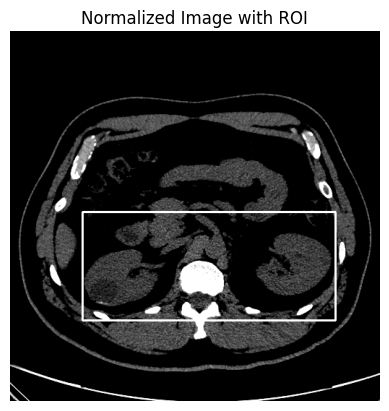

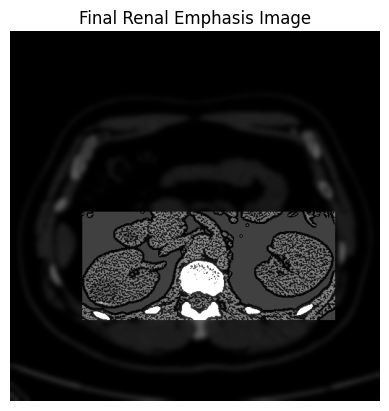

In [6]:


def display_image_with_roi(image, roi_coords, title="Image with ROI"):
    image_with_roi = image.copy()
    x, y, w, h = roi_coords
    cv2.rectangle(image_with_roi, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Blue rectangle for ROI
    plt.imshow(image_with_roi, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def window_level(image, level, width):
    min_intensity = level - (width / 2)
    max_intensity = level + (width / 2)
    windowed_image = np.clip(image, min_intensity, max_intensity)
    windowed_image = ((windowed_image - min_intensity) / (max_intensity - min_intensity)) * 255
    return windowed_image.astype(np.uint8)

def roi(image):
    roi_image = image
    gray_image = cv2.cvtColor(roi_image, cv2.COLOR_BGR2GRAY)
    standard_size = (512, 512)
    resized_image = cv2.resize(gray_image, standard_size)
    window_level_value = 40
    window_width_value = 400
    normalized_image = window_level(resized_image, window_level_value, window_width_value)
    roi_coords = (100, 250, 350, 150) 
    display_image_with_roi(normalized_image, roi_coords, title="Normalized Image with ROI")
    x, y, w, h = roi_coords
    roi = normalized_image[y:y+h, x:x+w]
    # Use adaptive thresholding to emphasize the renal area within the ROI
    roi_thresholded = cv2.adaptiveThreshold(roi, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    renal_mask = np.zeros_like(normalized_image)
    renal_mask[y:y+h, x:x+w] = roi_thresholded
    renal_emphasis = cv2.bitwise_and(normalized_image, renal_mask)
    blurred_background = cv2.GaussianBlur(normalized_image, (21, 21), 0)
    renal_area_only = cv2.bitwise_and(renal_emphasis, renal_mask)
    suppressed_background = cv2.bitwise_and(blurred_background, cv2.bitwise_not(renal_mask))
    final_image = cv2.addWeighted(renal_area_only, 1, suppressed_background, 0.5, 0)
    plt.imshow(final_image, cmap='gray')
    plt.title("Final Renal Emphasis Image")
    plt.axis('off')
    plt.show()


# Load the image
image_path = 'Cyst- (19).jpg'
preprocessed_image = cv2.imread(image_path)
preprocessed_image = roi(preprocessed_image)

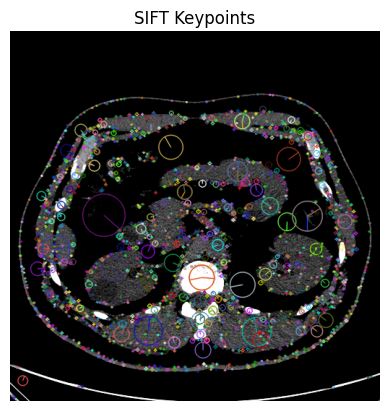

In [1]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image_path = 'Cyst- (19).jpg'
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
keypoints, descriptors = sift.detectAndCompute(gray, None)

# Draw keypoints
image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display image
plt.imshow(cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB))
plt.title('SIFT Keypoints')
plt.axis('off')
plt.show()


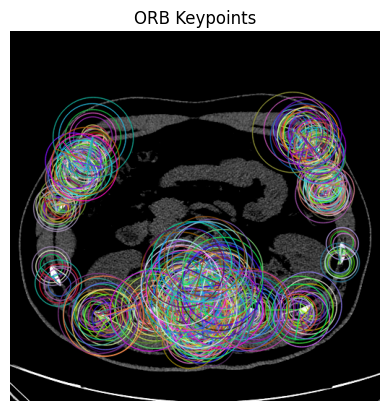

In [2]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image_path = 'Cyst- (19).jpg'
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Initialize ORB detector
orb = cv2.ORB_create()

# Detect keypoints and compute descriptors
keypoints, descriptors = orb.detectAndCompute(gray, None)

# Draw keypoints
image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display image
plt.imshow(cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB))
plt.title('ORB Keypoints')
plt.axis('off')
plt.show()


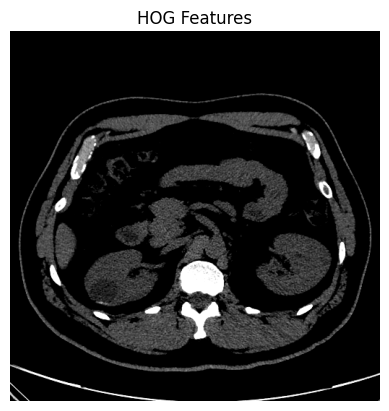

In [3]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image_path = 'Cyst- (19).jpg'
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Initialize HOG descriptor
hog = cv2.HOGDescriptor()

# Compute HOG features
h = hog.compute(gray)

# Display HOG image
plt.imshow(gray, cmap='gray')
plt.title('HOG Features')
plt.axis('off')
plt.show()


import cv2
import matplotlib.pyplot as plt

def extract_features(image_path, method='sift'):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    if method == 'sift':
        sift = cv2.SIFT_create()
        keypoints, descriptors = sift.detectAndCompute(gray, None)
        image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    elif method == 'orb':
        orb = cv2.ORB_create()
        keypoints, descriptors = orb.detectAndCompute(gray, None)
        image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    elif method == 'hog':
        hog = cv2.HOGDescriptor()
        h = hog.compute(gray)
        image_with_keypoints = gray  # HOG does not directly produce keypoints
        plt.title('HOG Features')
    else:
        raise ValueError("Invalid method. Choose from 'sift', 'orb', or 'hog'.")

    # Display image
    plt.imshow(cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB) if method != 'hog' else image_with_keypoints, cmap='gray' if method == 'hog' else None)
    plt.title(f'{method.upper()} Keypoints')
    plt.axis('off')
    plt.show()

# Example usage
extract_features('Cyst- (19).jpg', method='sift')
extract_features('Cyst- (19).jpg', method='orb')
extract_features('Cyst- (19).jpg', method='hog')
